# NB02 — Dataset Structure & Annotation Loading

**Primary Responsibility:** “Do we have the data, and can we read it?”

This notebook serves as the **Data Validation Engine and Single Source of Truth** for the entire project. It is strictly aligned with the **Official TVSum v1.1** release.

### Scope Note: Why No SumMe?
We are **not** using SumMe in this notebook. Per the project roadmap, SumMe is our **transfer test set**. It is handled in **NB09** to evaluate how well our model (trained on TVSum) generalizes to unseen data. Keeping NB02 focused on TVSum ensures a clean training index.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import subprocess
import json
import hashlib
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
import sys

%matplotlib inline
plt.style.use('ggplot')

## 1. Environment Detection & Official Mapping

We configure paths to find videos and metadata in the official dataset mount.

In [2]:
IS_KAGGLE = Path("/kaggle/input").exists()

if IS_KAGGLE:
    # User-specified dataset path
    VIDEO_DIR = Path("/kaggle/input/tvsum50-video-summarization")
    
    # Automated Discovery for Annotations (.tsv files)
    search_results = list(Path("/kaggle/input").glob("**/ydata-tvsum50-anno.tsv"))
    if search_results:
        ANNO_DIR = search_results[0].parent
    else:
        ANNO_DIR = Path("/kaggle/input/tvsum50-video-summarization/data")
else:
    VIDEO_DIR = Path("data/raw/TVSum/video")
    ANNO_DIR = Path("data/raw/TVSum/data")

PROCESSED_DIR = Path("data/processed")
RESULTS_DIR = Path("results/dataset_checks")

for d in [PROCESSED_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Environment: {'Kaggle' if IS_KAGGLE else 'Local'}")
print(f"Video Source: {VIDEO_DIR}")
print(f"Metadata Source: {ANNO_DIR}")

CATEGORY_MAP = {
    "VT": "Changing Vehicle Tire", "VU": "Getting Vehicle Unstuck", "GA": "Grooming an Animal",
    "MS": "Making Sandwich", "PK": "Parkour", "PR": "Parade", "FM": "Flash Mob Gathering",
    "BK": "Bee Keeping", "BT": "Attempting Bike Tricks", "DS": "Dog Show"
}

if not VIDEO_DIR.exists(): print(f"WARNING: Video directory missing: {VIDEO_DIR}")
if not ANNO_DIR.exists(): print(f"WARNING: Annotation directory missing: {ANNO_DIR}")

Environment: Kaggle
Video Source: /kaggle/input/tvsum50-video-summarization
Metadata Source: /kaggle/input/tvsum50-video-summarization/data


## 2. Utilities & Integrity

In [3]:
def normalize(s: str) -> str:
    return re.sub(r"[^a-z0-9]", "", s.lower())

def sha256(path: Path) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

## 3. Metadata Loading (Official v1.1)

We load video info and all 1,000 annotator rows (Zero Data Loss).

In [4]:
def load_official_v1_1(anno_dir: Path):
    info_path = anno_dir / "ydata-tvsum50-info.tsv"
    anno_path = anno_dir / "ydata-tvsum50-anno.tsv"
    
    # We use header=0 and names to skip the header row if present, or just header=None if it wasn't there.
    # Based on 'unmatched video_id', a header is definitely present.
    info_df = pd.read_csv(info_path, sep="\t", header=0, 
                         names=["cat_code", "video_id", "title", "url", "length"])
    
    anno_df = pd.read_csv(anno_path, sep="\t", header=0, 
                         names=["video_id", "cat_code", "scores"])
    
    return info_df, anno_df, anno_path

try:
    info_df, anno_df, anno_path_save = load_official_v1_1(ANNO_DIR)
    print(f"Loaded {len(info_df)} video metadata profiles.")
    print(f"Loaded {len(anno_df)} annotator rows.")
except Exception as e:
    print(f"Error loading metadata: {e}")

Loaded 50 video metadata profiles.
Loaded 999 annotator rows.


## 4. Video-Annotation Matching

In [5]:
def find_and_match(info_df, video_dir):
    all_vids = list(video_dir.glob("**/*.mp4"))
    by_norm_stem = defaultdict(list)
    for p in all_vids: by_norm_stem[normalize(p.stem)].append(p)
    
    mapping = {}
    unmatched = []
    for vid_id in info_df.video_id.unique():
        norm_id = normalize(str(vid_id))
        candidates = by_norm_stem.get(norm_id, [])
        
        if len(candidates) == 1:
            mapping[vid_id] = candidates[0]
        elif len(candidates) > 1:
            raise RuntimeError(f"Ambiguity detected for {vid_id}: Multiple candidates {candidates}")
        else:
            unmatched.append(vid_id)
            
    if unmatched:
        print(f"Unmatched Official IDs: {unmatched}")
            
    return mapping

video_map = find_and_match(info_df, VIDEO_DIR)
print(f"Matched {len(video_map)} files successfully.")

Matched 50 files successfully.


## 5. Metadata Probing

In [6]:
def probe_video(path: Path):
    try:
        cmd = [
            "ffprobe", "-v", "error", "-select_streams", "v:0",
            "-show_entries", "stream=duration,avg_frame_rate,nb_frames",
            "-of", "json", str(path)
        ]
        out = subprocess.check_output(cmd, stderr=subprocess.STDOUT).decode('utf-8')
        stream = json.loads(out)["streams"][0]
        
        duration = float(stream.get("duration", 0))
        num, den = stream.get("avg_frame_rate", "0/0").split("/")
        fps = float(num)/float(den) if den != "0" else None
        nb_frames = int(stream.get("nb_frames", 0))
        
        return duration, fps, nb_frames if nb_frames > 0 else None
    except:
        return None, None, None

## 6. Execution: Consolidate Index

In [7]:
rows = []
for vid_id, path in video_map.items():
    dur, fps, frames = probe_video(path)
    if dur is None: continue
    
    info_row = info_df[info_df.video_id == vid_id].iloc[0]
    
    rows.append({
        "video_id": vid_id, "category": CATEGORY_MAP.get(info_row.cat_code, "Unknown"),
        "category_code": info_row.cat_code, "title": info_row.title, "video_path": str(path),
        "annotation_path": str(anno_path_save), "duration_sec": dur, "fps": fps,
        "frame_count": frames, "sha256": sha256(path)
    })

index_df = pd.DataFrame(rows)
index_df.to_csv(PROCESSED_DIR / "tvsum_index.csv", index=False)
print(f"Source of Truth generated: {len(index_df)} videos.")

Source of Truth generated: 50 videos.


## 7. Deep Analysis: EDA

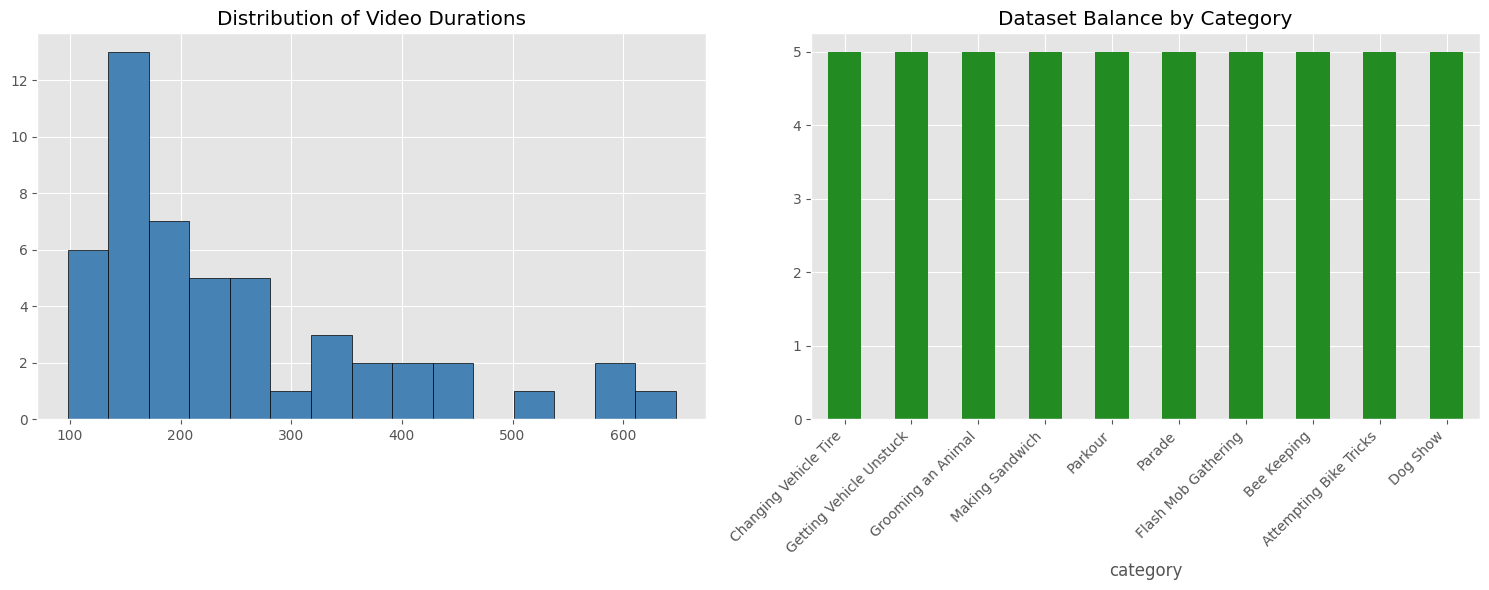

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].hist(index_df.duration_sec, bins=15, color='steelblue', edgecolor='black')
axes[0].set_title("Distribution of Video Durations")
index_df.category.value_counts().plot(kind='bar', ax=axes[1], color='forestgreen')
axes[1].set_title("Dataset Balance by Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 7.1 Human Consensus Visualization

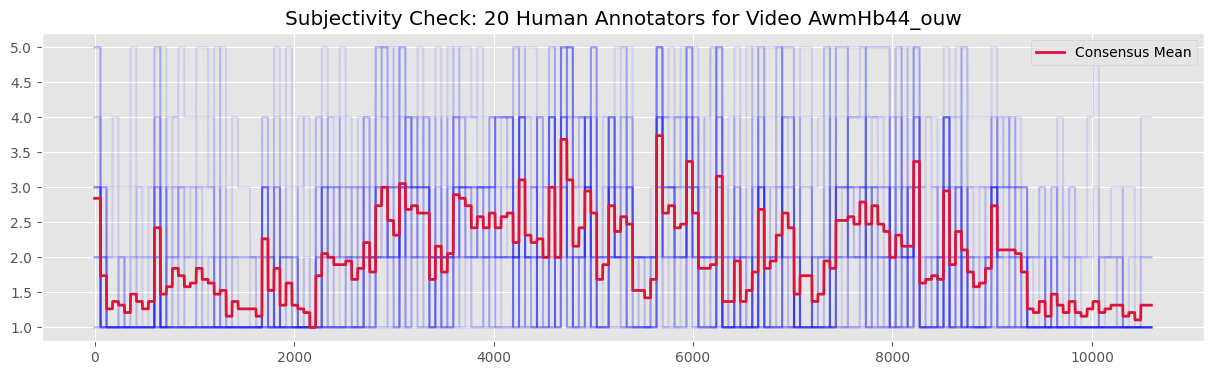

In [9]:
sample_vid = index_df.video_id.iloc[0]
raw_scores = anno_df[anno_df.video_id == sample_vid].scores.values
score_matrix = np.array([np.fromstring(s, sep=',') for s in raw_scores])

plt.figure(figsize=(15, 4))
for i in range(len(score_matrix)): plt.plot(score_matrix[i], alpha=0.1, color='blue')
plt.plot(score_matrix.mean(axis=0), color='crimson', linewidth=2, label='Consensus Mean')
plt.title(f"Subjectivity Check: 20 Human Annotators for Video {sample_vid}")
plt.legend()
plt.show()

## 8. Final Sanity Checks

In [10]:
summary = {"num_videos": len(index_df), "duration_avg": float(index_df.duration_sec.mean())}
with open(RESULTS_DIR / "tvsum_summary.json", "w") as f: json.dump(summary, f, indent=4)

assert index_df.video_id.is_unique
assert index_df.video_path.apply(lambda p: Path(p).exists()).all()
print("NB02 SUCCESS.")

NB02 SUCCESS.
